[View in Colaboratory](https://colab.research.google.com/github/J-Fo-S/models/blob/master/mobilenet_example_mod01.ipynb)

>[Prerequisites (downloading tensorflow_models and checkpoints)](#scrollTo=T_cETKXHDTXu)

>[Checkpoint based inference](#scrollTo=fxMe7_pkk_Vo)

>[Adversarial Hack](#scrollTo=PlwvpK3ElBk6)

https://github.com/tensorflow/models/tree/master/research/slim/nets/mobilenet


# Prerequisites (downloading tensorflow_models and checkpoints)

In [713]:
!git clone https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [714]:
from __future__ import print_function
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

checkpoint_name = 'mobilenet_v2_1.0_224' #@param
url = 'https://storage.googleapis.com/mobilenet_v2/checkpoints/' + checkpoint_name + '.tgz'
print('Downloading from ', url)
!wget {url}
print('Unpacking')
!tar -xvf {checkpoint_name}.tgz
checkpoint = checkpoint_name + '.ckpt'

display.clear_output()
print('Successfully downloaded checkpoint from ', url,
      '. It is available as', checkpoint)


Successfully downloaded checkpoint from  https://storage.googleapis.com/mobilenet_v2/checkpoints/mobilenet_v2_1.0_224.tgz . It is available as mobilenet_v2_1.0_224.ckpt


In [715]:
!wget https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG -O panda.jpg

--2018-07-11 19:10:13--  https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116068 (113K) [image/jpeg]
Saving to: ‘panda.jpg’

panda.jpg           100%[===================>] 113.35K  --.-KB/s    in 0.03s   

2018-07-11 19:10:14 (3.31 MB/s) - ‘panda.jpg’ saved [116068/116068]



In [0]:
# setup path
import sys
sys.path.append('/content/models/research/slim')

# Checkpoint based inference

In [717]:
import tensorflow as tf
from nets.mobilenet import mobilenet_v2

tf.reset_default_graph()

# For simplicity we just decode jpeg inside tensorflow.
# But one can provide any input obviously.
file_input = tf.placeholder(tf.string, (), name="input")

image = tf.image.decode_jpeg(tf.read_file(file_input))
#image_dec = np.asarray(PIL.Image.open('panda.jpg'))

images = tf.expand_dims(image, 0)
images = tf.cast(images, tf.float32) / 128.  - 1
images.set_shape((None, None, None, 3))
images = tf.image.resize_images(images, (224, 224))


# Note: arg_scope is optional for inference.
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
  logits, endpoints = mobilenet_v2.mobilenet(images)
  pl_cls_target = tf.placeholder(dtype=tf.int32)

  # Add a new loss-function. This is the cross-entropy.
  # See Tutorial #01 for an explanation of cross-entropy.
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=[pl_cls_target])

  # Get the gradient for the loss-function with regard to
  # the resized input image.
  #off_x = endpoints['layer_1'].eval(feed_dict={file_input: 'panda.jpg'})
  
  #t_off_x = tf.get_variable(off_x, name='off_x')
  
  gradient = tf.gradients(loss, endpoints['layer_1'])
  print(tf.get_default_graph())
  print(gradient)
  print(tf.get_default_graph())
  
# Restore using exponential moving average since it produces (1.5-2%) higher 
# accuracy
ema = tf.train.ExponentialMovingAverage(0.999)
vars = ema.variables_to_restore()

saver = tf.train.Saver(vars)  

[<tf.Tensor 'gradients/MobilenetV2/expanded_conv/depthwise/depthwise_grad/DepthwiseConv2dNativeBackpropInput:0' shape=(1, 112, 112, 32) dtype=float32>]


In [718]:
"""
from IPython import display
import pylab
from datasets import imagenet
import PIL
display.display(display.Image('panda.jpg'))

with tf.Session() as sess:
  saver.restore(sess,  checkpoint)
  x = endpoints['Predictions'].eval(feed_dict={file_input: 'panda.jpg'})
  print(tf.get_default_graph())
  
label_map = imagenet.create_readable_names_for_imagenet_labels()  
print("Top 1 prediction: ", x.argmax(),label_map[x.argmax()], x.max())
"""

'\nfrom IPython import display\nimport pylab\nfrom datasets import imagenet\nimport PIL\ndisplay.display(display.Image(\'panda.jpg\'))\n\nwith tf.Session() as sess:\n  saver.restore(sess,  checkpoint)\n  x = endpoints[\'Predictions\'].eval(feed_dict={file_input: \'panda.jpg\'})\n  print(tf.get_default_graph())\n  \nlabel_map = imagenet.create_readable_names_for_imagenet_labels()  \nprint("Top 1 prediction: ", x.argmax(),label_map[x.argmax()], x.max())\n'

# Adversarial Hack

In [719]:
print(logits)

Tensor("MobilenetV2/Logits/output:0", shape=(1, 1001), dtype=float32)


In [720]:
print(endpoints)

{'layer_1': <tf.Tensor 'MobilenetV2/Conv/Relu6:0' shape=(1, 112, 112, 32) dtype=float32>, 'layer_2': <tf.Tensor 'MobilenetV2/expanded_conv/output:0' shape=(1, 112, 112, 16) dtype=float32>, 'layer_3': <tf.Tensor 'MobilenetV2/expanded_conv_1/output:0' shape=(1, 56, 56, 24) dtype=float32>, 'layer_4': <tf.Tensor 'MobilenetV2/expanded_conv_2/output:0' shape=(1, 56, 56, 24) dtype=float32>, 'layer_5': <tf.Tensor 'MobilenetV2/expanded_conv_3/output:0' shape=(1, 28, 28, 32) dtype=float32>, 'layer_6': <tf.Tensor 'MobilenetV2/expanded_conv_4/output:0' shape=(1, 28, 28, 32) dtype=float32>, 'layer_7': <tf.Tensor 'MobilenetV2/expanded_conv_5/output:0' shape=(1, 28, 28, 32) dtype=float32>, 'layer_8': <tf.Tensor 'MobilenetV2/expanded_conv_6/output:0' shape=(1, 14, 14, 64) dtype=float32>, 'layer_9': <tf.Tensor 'MobilenetV2/expanded_conv_7/output:0' shape=(1, 14, 14, 64) dtype=float32>, 'layer_10': <tf.Tensor 'MobilenetV2/expanded_conv_8/output:0' shape=(1, 14, 14, 64) dtype=float32>, 'layer_11': <tf.Te

In [721]:
# Set the graph for the Inception model as the default graph,
# so that all changes inside this with-block are done to that graph.
#with model.graph.as_default():

#with tf.contrib.slim.arg_scope(mobilenet.training_scope()):
#     logits, endpoints = mobilenet_base(...)  

#new_graph = tf.Graph()

#with new_graph.as_default():
#with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
"""
with tf.Session() as sess:
  saver.restore(sess,  checkpoint)
  # This will be set to e.g. 300 for the 'bookcase' class.
  pl_cls_target = tf.placeholder(dtype=tf.int32)

  # Add a new loss-function. This is the cross-entropy.
  # See Tutorial #01 for an explanation of cross-entropy.
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=[pl_cls_target])

  # Get the gradient for the loss-function with regard to
  # the resized input image.
  #off_x = endpoints['layer_1'].eval(feed_dict={file_input: 'panda.jpg'})
  
  #t_off_x = tf.get_variable(off_x, name='off_x')
  
  gradient = tf.gradients(loss, endpoints['layer_1'])
  print(tf.get_default_graph())
  print(gradient)
"""

"\nwith tf.Session() as sess:\n  saver.restore(sess,  checkpoint)\n  # This will be set to e.g. 300 for the 'bookcase' class.\n  pl_cls_target = tf.placeholder(dtype=tf.int32)\n\n  # Add a new loss-function. This is the cross-entropy.\n  # See Tutorial #01 for an explanation of cross-entropy.\n  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=[pl_cls_target])\n\n  # Get the gradient for the loss-function with regard to\n  # the resized input image.\n  #off_x = endpoints['layer_1'].eval(feed_dict={file_input: 'panda.jpg'})\n  \n  #t_off_x = tf.get_variable(off_x, name='off_x')\n  \n  gradient = tf.gradients(loss, endpoints['layer_1'])\n  print(tf.get_default_graph())\n  print(gradient)\n"

In [722]:
sess = tf.Session(graph=tf.get_default_graph())
saver.restore(sess,  checkpoint)
#init = tf.global_variables_initializer()
#sess.run(init)

INFO:tensorflow:Restoring parameters from mobilenet_v2_1.0_224.ckpt


In [0]:
def find_adversary_noise(image_path, cls_target, noise_limit=3.0,
                         required_score=0.99, max_iterations=100):
    """
    Find the noise that must be added to the given image so
    that it is classified as the target-class.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    max_iterations: Max number of optimization iterations to perform.
    """
    
    # Get predicted output from softmax layer
    y_pred = endpoints['Predictions']
    
    # Create a feed-dict with the image.
    #feed_dict = imagenet._create_feed_dict(image_path=image_path)

    # Use TensorFlow to calculate the predicted class-scores
    # (aka. probabilities) as well as the resized image.
    pred, image = sess.run([y_pred, endpoints['layer_1']],
                              feed_dict={file_input:image_path})
  
    #pred = y_pred.eval(feed_dict={file_input: image_path})
    #image = Image.open(image_path)
    #image = np.asarray(image)
  
    # Convert to one-dimensional array.
    pred = np.squeeze(pred)

    # Predicted class-number.
    cls_source = np.argmax(pred)

    # Score for the predicted class (aka. probability or confidence).
    score_source_org = pred.max()

    # Names for the source and target classes.
    name_source = label_map[cls_source]
    name_target = label_map[cls_target]

    # Initialize the noise to zero.
    noise = 0
    
    image_dec = np.asarray(PIL.Image.open(image_path))

    # Perform a number of optimization iterations to find
    # the noise that causes mis-classification of the input image.
    for i in range(max_iterations):
        print("Iteration:", i)
  
        # The noisy image is just the sum of the input image and noise.
        noisy_image = image + noise

        # Ensure the pixel-values of the noisy image are between
        # 0 and 255 like a real image. If we allowed pixel-values
        # outside this range then maybe the mis-classification would
        # be due to this 'illegal' input breaking the Inception model.
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)
        
        #noisy_image = tf.image.encode_jpeg(noisy_image)
        #noisy_image = ','.join(map(str,noisy_image))
        
        # Create a feed-dict. This feeds the noisy image to the
        # tensor in the graph that holds the resized image, because
        # this is the final stage for inputting raw image data.
        # This also feeds the target class-number that we desire.
        feed_dict = {endpoints['layer_1']: noisy_image,
                     pl_cls_target: cls_target}

        # Calculate the predicted class-scores as well as the gradient.
        pred, grad = sess.run([y_pred, gradient],
                                 feed_dict=feed_dict)
        #pred = y_pred.eval(feed_dict={
        #    file_input: noisy_image})
        #grad = gradient.eval()

        # Convert the predicted class-scores to a one-dim array.
        pred = np.squeeze(pred)

        # The scores (probabilities) for the source and target classes.
        score_source = pred[cls_source]
        score_target = pred[cls_target]

        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        # The gradient now tells us how much we need to change the
        # noisy input image in order to move the predicted class
        # closer to the desired target-class.

        # Calculate the max of the absolute gradient values.
        # This is used to calculate the step-size.
        grad_absmax = np.abs(grad).max()
        
        # If the gradient is very small then use a lower limit,
        # because we will use it as a divisor.
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10

        # Calculate the step-size for updating the image-noise.
        # This ensures that at least one pixel colour is changed by 7.
        # Recall that pixel colours can have 255 different values.
        # This step-size was found to give fast convergence.
        step_size = 7 / grad_absmax

        # Print the score etc. for the source-class.
        msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_source, cls_source, name_source))

        # Print the score etc. for the target-class.
        msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_target, cls_target, name_target))

        # Print statistics for the gradient.
        msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
        print(msg.format(grad.min(), grad.max(), step_size))

        # Newline.
        print()

        # If the score for the target-class is not high enough.
        if score_target < required_score:
            # Update the image-noise by subtracting the gradient
            # scaled by the step-size.
            noise -= step_size * grad

            # Ensure the noise is within the desired range.
            # This avoids distorting the image too much.
            noise = np.clip(a=noise,
                            a_min=-noise_limit,
                            a_max=noise_limit)
        else:
            # Abort the optimization because the score is high enough.
            break

    return image.squeeze(), noisy_image.squeeze(), noise, \
           name_source, name_target, \
           score_source, score_source_org, score_target

In [0]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm
  

def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def adversary_example(image_path, cls_target,
                      noise_limit, required_score):
    """
    Find and plot adversarial noise for the given image.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    """

    # Find the adversarial noise.
    image, noisy_image, noise, \
    name_source, name_target, \
    score_source, score_source_org, score_target = \
        find_adversary_noise(image_path=image_path,
                             cls_target=cls_target,
                             noise_limit=noise_limit,
                             required_score=required_score)

    # Plot the image and the noise.
    plot_images(image=image, noise=noise, noisy_image=noisy_image,
                name_source=name_source, name_target=name_target,
                score_source=score_source,
                score_source_org=score_source_org,
                score_target=score_target)

    # Print some statistics for the noise.
    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))

Iteration: 0
Source score:  85.00%, class-number:  389, class-name: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
Target score:   0.01%, class-number:  300, class-name: meerkat, mierkat
Gradient min: -0.150164, max:  0.251689, stepsize:     27.81

Iteration: 1
Source score:   0.02%, class-number:  389, class-name: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
Target score:   0.01%, class-number:  300, class-name: meerkat, mierkat
Gradient min: -0.339750, max:  0.228604, stepsize:     20.60

Iteration: 2
Source score:   0.18%, class-number:  389, class-name: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
Target score:   0.19%, class-number:  300, class-name: meerkat, mierkat
Gradient min: -0.064060, max:  0.069337, stepsize:    100.96

Iteration: 3
Source score:   0.32%, class-number:  389, class-name: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
Target score:   0.28%, class-number:  300, class-name: meerkat

TypeError: ignored

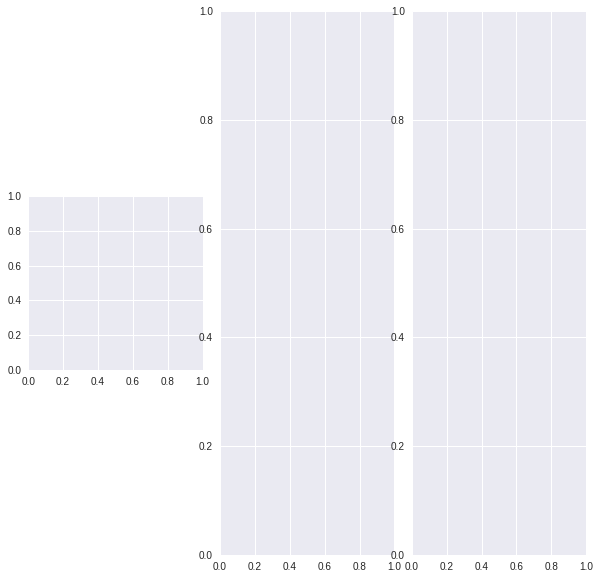

In [725]:
image_path = "panda.jpg"
print(tf.get_default_graph())

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

In [53]:
print(noisy_image)

NameError: ignored